# Pretrained CNN (VGG)


In [ ]:
!pip install import-ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=146ff22728369c5d665c771b48c72c93cdf5229c27944489ccb01f3e5d32eda3
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/MyDrive/Colab'

/content/gdrive/MyDrive/Colab


In [ ]:
import import_ipynb
import os
import tensorflow as tf
import numpy as np
import Utils as utils
from sklearn.utils import class_weight
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Data preprocessing

In [ ]:
BATCH_SIZE = 64

In [ ]:
#Get datasets
images, labels = utils.load_training()
images, labels = utils.binarize(images, labels, 'mass_calcification')
images = utils.rescale(images)

#Shuffle
images, labels = utils.shuffle_dataset(images, labels)

In [ ]:
images = [np.stack((images[i],)*3, axis=2) for i in range (len(images))]
images = np.array(images)
utils.properties(images)

Properties: 
Shape: (2676, 150, 150, 3)
Min: 0.0
Max: 1.0
Diff: 1.0
Type of elements: float64


In [ ]:
data_augmentation = ImageDataGenerator(
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2,
    )


training_set = data_augmentation.flow(images, labels,seed=42, batch_size=BATCH_SIZE, subset='training')
validation_set = data_augmentation.flow(images, labels, seed=42, batch_size=BATCH_SIZE, subset='validation')


In [ ]:
weights = class_weight.compute_class_weight('balanced', np.unique(labels), labels)
weights = dict(enumerate(weights))
print('Class weights: ', weights)

Class weights:  {0: 1.0985221674876848, 1: 0.9176954732510288}


## Training

### Network architecture

In [ ]:
vgg16net = tf.keras.applications.VGG16(
  include_top=False,
  input_shape=(150,150,3),
  weights='imagenet')

vgg16net.summary()

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.Model(inputs=vgg16net.input, outputs=vgg16net.get_layer('block3_pool').output, name="vgg16"),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(256, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')                        
])
model.get_layer("vgg16").trainable=False
model.summary()

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=['accuracy'])

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20,  restore_best_weights=True),
             tf.keras.callbacks.ModelCheckpoint('models/vgg_mc_64_3.h5', monitor='val_accuracy', mode='max',
                                                save_best_only=True)]
history = model.fit(
      training_set,
      epochs=100,
      callbacks = callbacks,
      shuffle=False,
      verbose=1,
      validation_data=validation_set,
      batch_size=BATCH_SIZE)

Epoch 1/100
34/34 [==============================] - 13s 362ms/step - loss: 3.0186 - accuracy: 0.5400 - val_loss: 0.7907 - val_accuracy: 0.5346
Epoch 2/100
34/34 [==============================] - 12s 364ms/step - loss: 0.9268 - accuracy: 0.5653 - val_loss: 0.6555 - val_accuracy: 0.5869
Epoch 3/100
34/34 [==============================] - 12s 365ms/step - loss: 0.7036 - accuracy: 0.6328 - val_loss: 0.6937 - val_accuracy: 0.5720
Epoch 4/100
34/34 [==============================] - 12s 362ms/step - loss: 0.6189 - accuracy: 0.6870 - val_loss: 0.5042 - val_accuracy: 0.7252
Epoch 5/100
34/34 [==============================] - 12s 367ms/step - loss: 0.5470 - accuracy: 0.7118 - val_loss: 0.4469 - val_accuracy: 0.7533
Epoch 6/100
34/34 [==============================] - 12s 368ms/step - loss: 0.6478 - accuracy: 0.6741 - val_loss: 0.6193 - val_accuracy: 0.6935
Epoch 7/100
34/34 [==============================] - 12s 353ms/step - loss: 0.5125 - accuracy: 0.7590 - val_loss: 0.8581 - val_accuracy:

### Training plots

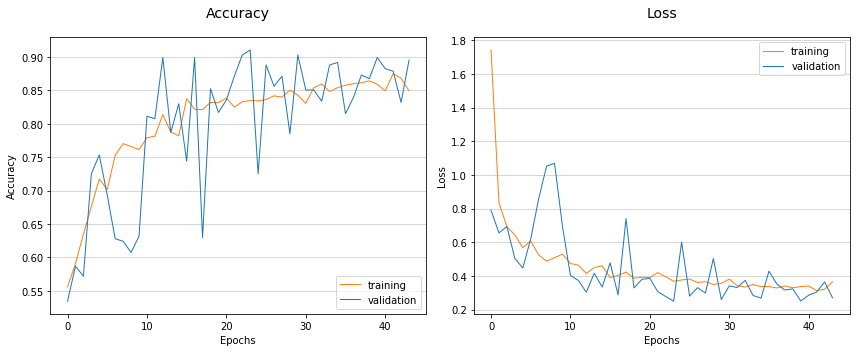

In [ ]:
utils.plot_training(history.history['accuracy'], 
                    history.history['loss'], 
                    history.history['val_accuracy'], 
                    history.history['val_loss'], 
                    44,
                    'figures/vgg_plotVGG16_mc_64_3.png')

## Evaluation

In [ ]:
test_images, test_labels = utils.load_test()
test_dataset, test_lab = utils.binarize(test_images, test_labels, 'mass_calcification')
test_dataset = utils.rescale(test_dataset)
test_dataset = [np.stack((test_dataset[i],)*3, axis=2) for i in range (len(test_dataset))]

11/11 [==============================] - 0s 24ms/step
Performances: 
Accuracy:  0.8601190476190477
Precision:  0.8616434224292127
Recall:  0.8601190476190477
F1-score:  0.8602642308620025
AUC:  0.8612781553570793


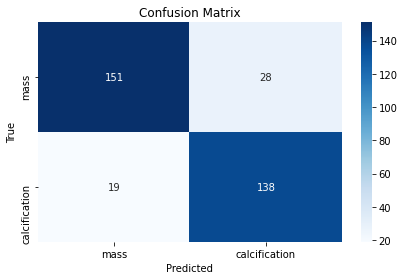

In [ ]:
test_dataset = np.array(test_dataset)
predicted = model.predict(test_dataset, verbose=1)
predicted = [0 if x <=0.5 else 1 for x in predicted]
utils.evaluate_classifier(test_lab, predicted)

utils.plot_confusion_matrix(test_lab, predicted, ['mass', 'calcification'], 'figures/vgg_mc_cm_64_3.png')